In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset
Ilmi, M. F. (2022). Spotify App Reviews 2022. Kaggle. https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022/

License: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)

In [25]:
# I'm using Google Colab for the codes
# Read the csv file from the website source above on your personal directory

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab/P2: Spotify Reviews/reviews.csv' # modify as you need

df = pd.read_csv(file_path)
df = df.sample(frac=1).reset_index(drop=True) # Randomize before previewing the dataset
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-04 23:54:36,Usually I use use spotify daily but recently t...,1,0,NaN
1,2022-04-14 16:54:31,Since its stupid automatic payments I'll be li...,1,1,NaN
2,2022-06-17 02:20:52,As long as you have Spotify premium this is th...,5,0,NaN
3,2022-04-28 05:46:53,"The payed version is very broken, for Android ...",2,7,NaN
4,2022-06-24 08:58:55,My experience with this app has been good so f...,4,0,NaN
5,2022-07-06 05:46:23,Best free streaming app,5,0,NaN
6,2022-04-05 14:23:59,Only way to play a playlist is on shuffle. Can...,1,0,NaN
7,2022-05-02 12:56:19,For being in 2022... this app acts like the be...,1,0,NaN
8,2022-06-14 08:48:15,I understand that mobile apps are design to be...,2,5,NaN
9,2022-02-21 13:57:19,"I've got spofity premium, downloaded a few son...",1,0,NaN


In [26]:
df['Date'] = pd.to_datetime(df['Time_submitted']).dt.date

#To insert the 'Date' column as the first column
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df.head(10)

,Date,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-04,2022-07-04 23:54:36,Usually I use use spotify daily but recently t...,1,0,NaN
1,2022-04-14,2022-04-14 16:54:31,Since its stupid automatic payments I'll be li...,1,1,NaN
2,2022-06-17,2022-06-17 02:20:52,As long as you have Spotify premium this is th...,5,0,NaN
3,2022-04-28,2022-04-28 05:46:53,"The payed version is very broken, for Android ...",2,7,NaN
4,2022-06-24,2022-06-24 08:58:55,My experience with this app has been good so f...,4,0,NaN
5,2022-07-06,2022-07-06 05:46:23,Best free streaming app,5,0,NaN
6,2022-04-05,2022-04-05 14:23:59,Only way to play a playlist is on shuffle. Can...,1,0,NaN
7,2022-05-02,2022-05-02 12:56:19,For being in 2022... this app acts like the be...,1,0,NaN
8,2022-06-14,2022-06-14 08:48:15,I understand that mobile apps are design to be...,2,5,NaN
9,2022-02-21,2022-02-21 13:57:19,"I've got spofity premium, downloaded a few son...",1,0,NaN


# Quick EDA
Previewing how the ratings are distributed through the dataset. This
- The general EDA using describe() function
- Pie Chart to see each individual rating from 1 star to 5 stars
- Time-series chart to view the average ratings based on the submitted date

In [27]:
# Provide the general statistics using describe() function from pandas:
df.describe().round(3)

,Rating,Total_thumbsup
count,61594.000,61594.000
mean,3.156,7.649
std,1.673,89.323
min,1.000,0.000
25%,1.000,0.000
50%,3.000,0.000
75%,5.000,1.000
max,5.000,8195.000


In [28]:
# Count the rating frequency (how many 1-star reviews and 5-star reviews)
rating_counts = df['Rating'].value_counts()
rating_counts.index = rating_counts.index.astype(str) + "-star"
rating_counts

,count
Rating,
5-star,22095
1-star,17653
4-star,7842
2-star,7118
3-star,6886


In [29]:
# Adding percentage column beside the "count" column in rating_counts table
rating_shares = round((rating_counts / rating_counts.sum()) * 100,1)
rating_df = pd.DataFrame({'count': rating_counts, 'share': rating_shares})
rating_df

,count,share
Rating,,
5-star,22095,35.9
1-star,17653,28.7
4-star,7842,12.7
2-star,7118,11.6
3-star,6886,11.2


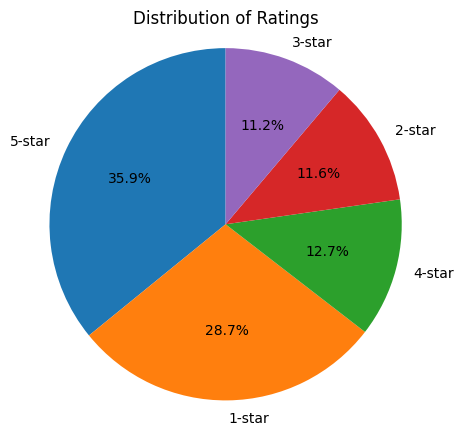

In [7]:
# Plot the ratings above using pie chart
plt.figure(figsize=(5, 5))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

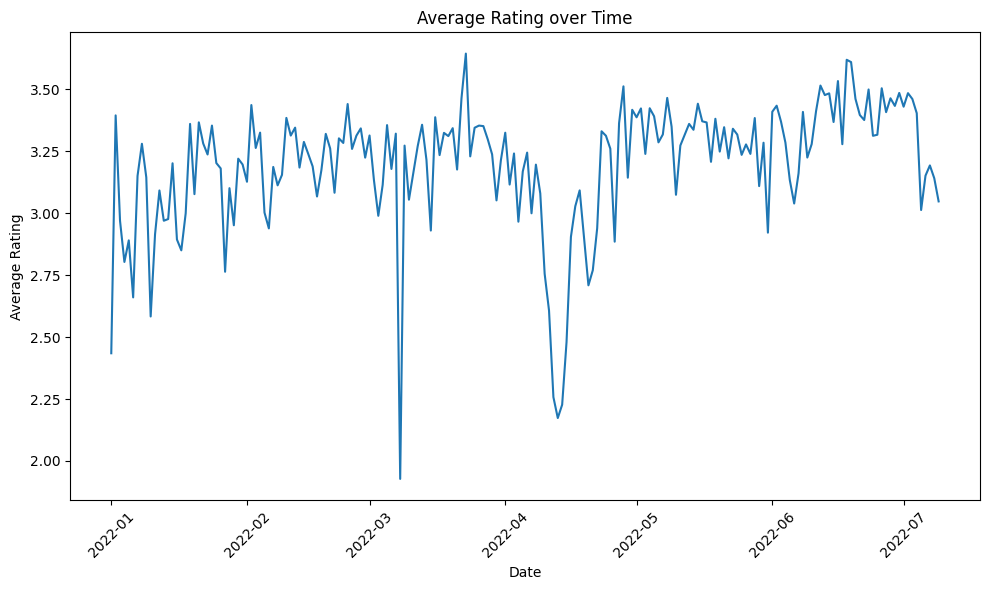

In [31]:
# aggregate the ratings using mean for each date, then plot using line chart
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])
daily_ratings = df.groupby(df['Date'])['Rating'].mean()

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(daily_ratings.index, daily_ratings.values)
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Preprocessing

## Finding the outliers: Dates with very-low aggregate ratings?
Getting know the overall reviews of some of the dates with aggregate ratings below 2.25

In [32]:
# Sort the avg rating values of each date
daily_ratings = daily_ratings.reset_index()
daily_ratings.sort_values(by = 'Rating', ascending=True)

,Date,Rating
66,2022-03-08,1.927457
102,2022-04-13,2.173252
103,2022-04-14,2.227048
101,2022-04-12,2.257697
0,2022-01-01,2.434783
...,...,...
162,2022-06-12,3.515815
166,2022-06-16,3.533958
169,2022-06-19,3.610577
168,2022-06-18,3.619870


In [33]:
# Preview the review data from March 8
df['Date'] = pd.to_datetime(df['Date'])
march8_reviews = df[df['Date'] == pd.to_datetime('2022-03-08')]
march8_reviews

,Date,Time_submitted,Review,Rating,Total_thumbsup,Reply
16,2022-03-08,2022-03-08 09:51:05,After the last updated the scroll bar just sto...,1,25,NaN
28,2022-03-08,2022-03-08 18:45:40,"Logged me out of my phone, will not recognize ...",1,2,NaN
31,2022-03-08,2022-03-08 18:31:32,Loved the app until recently. Froze so I close...,1,1,NaN
92,2022-03-08,2022-03-08 18:48:12,"I love this app for years now, I have been pay...",1,0,NaN
141,2022-03-08,2022-03-08 15:58:26,Pretty good experience except it will pull unr...,4,0,NaN
...,...,...,...,...,...,...
61405,2022-03-08,2022-03-08 18:55:56,"over all good, have some issues where music wi...",4,1,NaN
61479,2022-03-08,2022-03-08 17:49:31,New update it has gone really weird and is not...,1,0,NaN
61505,2022-03-08,2022-03-08 18:20:49,I think a button to replay would be nice buy o...,3,0,NaN
61564,2022-03-08,2022-03-08 18:36:33,"Spotify was working fine until yesterday, and ...",3,2,NaN


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


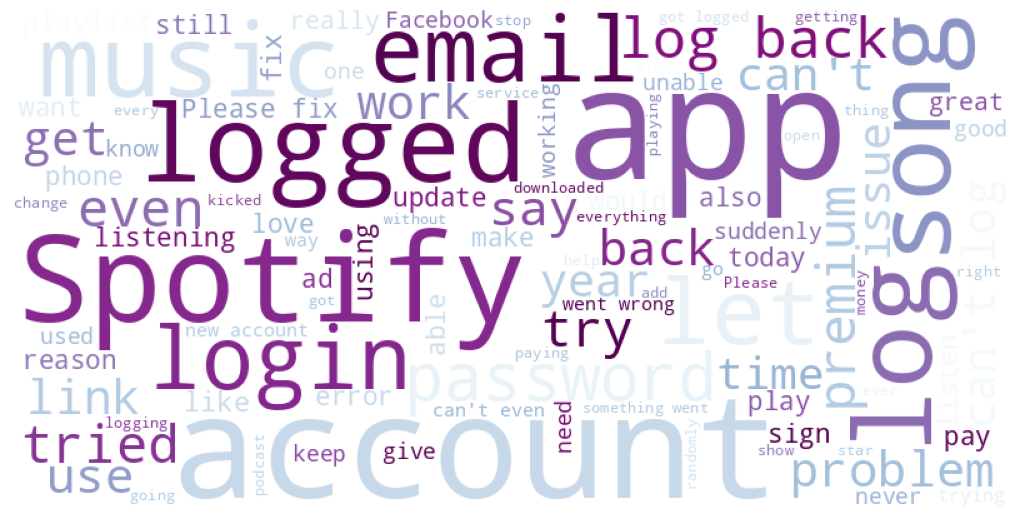

In [34]:
# Plot a word cloud for specific_date_reviews, take only keywords

# !pip install wordcloud # Download if not available
!pip install nltk
import nltk # Import the nltk module here
nltk.download('stopwords') # Download if not available

from nltk.corpus import stopwords
from wordcloud import WordCloud

# Generating the word cloud
text = " ".join(review for review in march8_reviews['Review']) # Generate by joining the texts first
english_stopwords = set(stopwords.words('english')) # Get English stopwords

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=english_stopwords,
    max_words=100,
    colormap='BuPu_r'
).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Apparently the spotify app could not be logged in even by the paid users on
March 8, 2022. Let's see for other dates (we'll take April 13 and April 14).

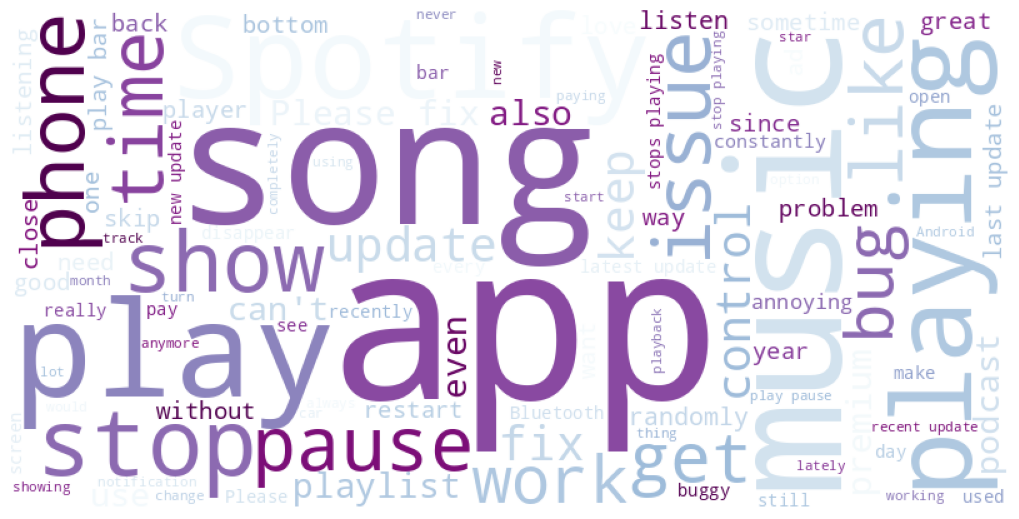

In [35]:
# Getting the reviews from April 13 to April 14, 2022
april_low_reviews = df[
    (df['Date'] == pd.to_datetime('2022-04-13')) |
    (df['Date'] == pd.to_datetime('2022-04-14'))]

# Generating the word cloud
text = " ".join(review for review in april_low_reviews['Review']) # Generate by joining the texts first

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=english_stopwords,
    max_words=100,
    colormap='BuPu_r'
).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

I see. Most likely the spotify had some playback issues on April 13 and 14.

## Dropping outlier reviews
After we identified the date very-low aggregate scores above, we concluded that these sudden jump in low-rating reviews were due to major technical errors in the app that had already been quickly fixed later. So we don't need to include these reviews for later processes.

Before deprecating, let's see the z-score of each date, starting from the lowest aggregated ratings first.


In [36]:
# Add the zscore column
daily_ratings.loc[:, 'zscore'] = (daily_ratings['Rating'] - daily_ratings['Rating'].mean()) / daily_ratings['Rating'].std()

# Sort by rating and print the first 15
sorted_items = daily_ratings.sort_values(by='zscore', ascending=True)
sorted_items

,Date,Rating,zscore
66,2022-03-08,1.927457,-4.856403
102,2022-04-13,2.173252,-3.916333
103,2022-04-14,2.227048,-3.710584
101,2022-04-12,2.257697,-3.593367
0,2022-01-01,2.434783,-2.916083
...,...,...,...
162,2022-06-12,3.515815,1.218440
166,2022-06-16,3.533958,1.287829
169,2022-06-19,3.610577,1.580867
168,2022-06-18,3.619870,1.616411


Based on the table above, We'll deprecate reviews with dates that have the z-scores below -3, which means
- March 8
- April 12 to April 14

In [37]:
# Dates to drop
dates_to_drop = [pd.to_datetime('2022-03-08').date(),
                 pd.to_datetime('2022-04-12').date(),
                 pd.to_datetime('2022-04-13').date(),
                 pd.to_datetime('2022-04-14').date()]

# Drop rows where 'Date' is in dates_to_drop
df = df[~df['Date'].isin(dates_to_drop)]

<ipython-input-37-e254588d02dc>:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df = df[~df['Date'].isin(dates_to_drop)]


Preview using pie chart after dropping the outlier reviews.

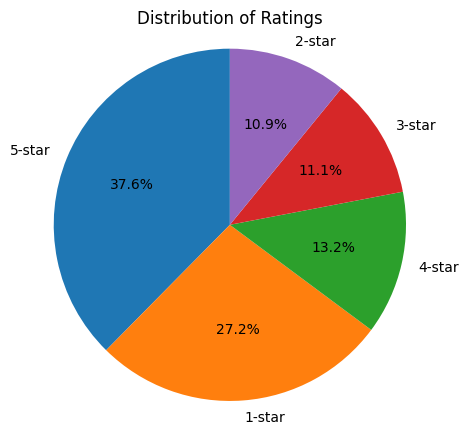

In [38]:
rating_counts = df['Rating'].value_counts()
rating_counts.index = rating_counts.index.astype(str) + "-star"

# Plot the ratings above using pie chart
plt.figure(figsize=(5, 5))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We can see slight increase on the 5-star section and slight decrease on the 1-star section

# Applying Shifterator analysis
Starting from here, we will compare how the reviews from the 5-star ratings generally differ from the 1-star ratings using a shifterator analysis.

In [39]:
# Apply shifterator analysis to compare 1-star ratings and 5-star ratings from the df table using the shifterator library
# !pip install shifterator --upgrade # Download if not available yet
import shifterator as sh

# Prepare the data for Shifterator
one_star_reviews = df[df['Rating'] == 1]['Review'].tolist()
five_star_reviews = df[df['Rating'] == 5]['Review'].tolist()

## Dropping common English words
Punctuations and common words like "A, A, The, Not, Or" are deprecated starting from here. We'll use the "stopwords" library.

In [40]:
# drop some words based on english stop from one_star_reviews and five_star_reviews
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

# Function to remove stopwords from a list of strings:
def remove_stopwords(text_list):
    return [" ".join([word for word in review.lower().split() if word not in english_stopwords])
            for review in text_list]

# Apply the function to your one_star_reviews and five_star_reviews lists
one_star_reviews = remove_stopwords(one_star_reviews)
five_star_reviews = remove_stopwords(five_star_reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# remove punctuations in one_star_reviews and five_star_reviews
import string

def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

one_star_reviews = [remove_punctuation(review) for review in one_star_reviews]
five_star_reviews = [remove_punctuation(review) for review in five_star_reviews]

In [42]:
# prompt: count the word frequency from one_star_review and five_star_review. Use dict type

from collections import defaultdict

def word_frequency(text_list):
    word_freq = defaultdict(int)
    for text in text_list:
        for word in text.split():
            word_freq[word] += 1
    return dict(word_freq)

one_star_freq = word_frequency(one_star_reviews)
five_star_freq = word_frequency(five_star_reviews)

# Preview the first 10 words from each list
print("First 10 words from one_star_freq:")
for i, (word, freq) in enumerate(one_star_freq.items()):
  if i >= 10:
    break
  print(f"{word}: {freq}")

print("\nFirst 10 words from five_star_freq:")
for i, (word, freq) in enumerate(five_star_freq.items()):
  if i >= 10:
    break
  print(f"{word}: {freq}")

First 10 words from one_star_freq:
usually: 72
use: 1548
spotify: 4859
daily: 94
recently: 309
theres: 366
glitch: 85
shows: 330
logo: 82
open: 746

First 10 words from five_star_freq:
long: 301
spotify: 7021
premium: 2034
best: 3671
app: 10508
world: 228
free: 1101
streaming: 711
music: 12019
clear: 145


## Dropping common words from both lists
Because these are Spotify reviews, some words like "music, apps, songs, play" are common either in positive or negative reviews. We started to deprecate these common words here.

In [43]:
# Take the top 20 words from each dict (one_star_reviews, five_star_reviews)
import heapq

def top_n_words(freq_dict, n=50):
    return dict(heapq.nlargest(n, freq_dict.items(), key=lambda item: item[1]))

top_50_one_star = top_n_words(one_star_freq)
top_50_five_star = top_n_words(five_star_freq)

print("Top 50 words in one-star reviews:", top_50_one_star)
print("\nTop 50 words in five-star reviews:", top_50_five_star)

Top 50 words in one-star reviews: {'app': 10090, 'song': 5503, 'songs': 5302, 'spotify': 4859, 'music': 4723, 'play': 4648, 'cant': 3908, 'even': 3120, 'premium': 2950, 'listen': 2830, 'ads': 2807, 'playlist': 2340, 'want': 2314, 'playing': 2258, 'like': 2224, 'update': 2124, 'get': 1823, 'fix': 1806, 'time': 1682, 'every': 1607, 'use': 1548, 'one': 1515, 'it': 1453, 'phone': 1378, 'please': 1322, 'still': 1191, 'back': 1161, 'work': 1145, 'stop': 1096, 'pay': 1077, 'many': 1050, 'good': 1037, 'new': 1030, 'also': 994, 'free': 984, 'keeps': 978, 'plays': 948, 'really': 922, 'annoying': 886, 'would': 878, 'without': 876, 'podcasts': 875, 'way': 868, 'used': 860, 'go': 859, 'playlists': 845, 'shuffle': 829, 'skip': 825, 'listening': 825, 'downloaded': 807}

Top 50 words in five-star reviews: {'music': 12019, 'app': 10508, 'spotify': 7021, 'love': 5942, 'songs': 4059, 'great': 3965, 'best': 3671, 'good': 3514, 'listen': 2931, 'like': 2854, 'use': 2239, 'song': 2172, 'premium': 2034, 'easy

In [44]:
# Find the common words between one_star_reviews and five_star_reviews
common_words = set(top_50_one_star.keys()) & set(top_50_five_star.keys())
print(common_words)

{'time', 'free', 'cant', 'spotify', 'listening', 'premium', 'playlists', 'really', 'get', 'songs', 'playlist', 'would', 'one', 'many', 'want', 'every', 'listen', 'ads', 'it', 'use', 'music', 'song', 'app', 'even', 'like', 'play', 'good', 'podcasts', 'new', 'also'}


We finally got the list of the common words. Now let's deprecate them

In [45]:
# Drop common words from top_50_one_star and top_50_five_star
for word in common_words:
    if word in top_50_one_star:
        del top_50_one_star[word]
    if word in top_50_five_star:
        del top_50_five_star[word]

print("Updated top 50 words in one-star reviews:", top_50_one_star)
print("\nUpdated top 50 words in five-star reviews:", top_50_five_star)

Updated top 50 words in one-star reviews: {'playing': 2258, 'update': 2124, 'fix': 1806, 'phone': 1378, 'please': 1322, 'still': 1191, 'back': 1161, 'work': 1145, 'stop': 1096, 'pay': 1077, 'keeps': 978, 'plays': 948, 'annoying': 886, 'without': 876, 'way': 868, 'used': 860, 'go': 859, 'shuffle': 829, 'skip': 825, 'downloaded': 807}

Updated top 50 words in five-star reviews: {'love': 5942, 'great': 3965, 'best': 3671, 'easy': 1762, 'amazing': 1307, 'find': 1146, 'much': 1118, 'ever': 1027, 'better': 933, 'using': 920, 'favorite': 920, 'awesome': 907, 'quality': 891, 'enjoy': 879, 'years': 844, 'nice': 826, 'always': 825, 'experience': 794, 'thank': 772, 'recommend': 754}


## Plotting the Shifterator chart

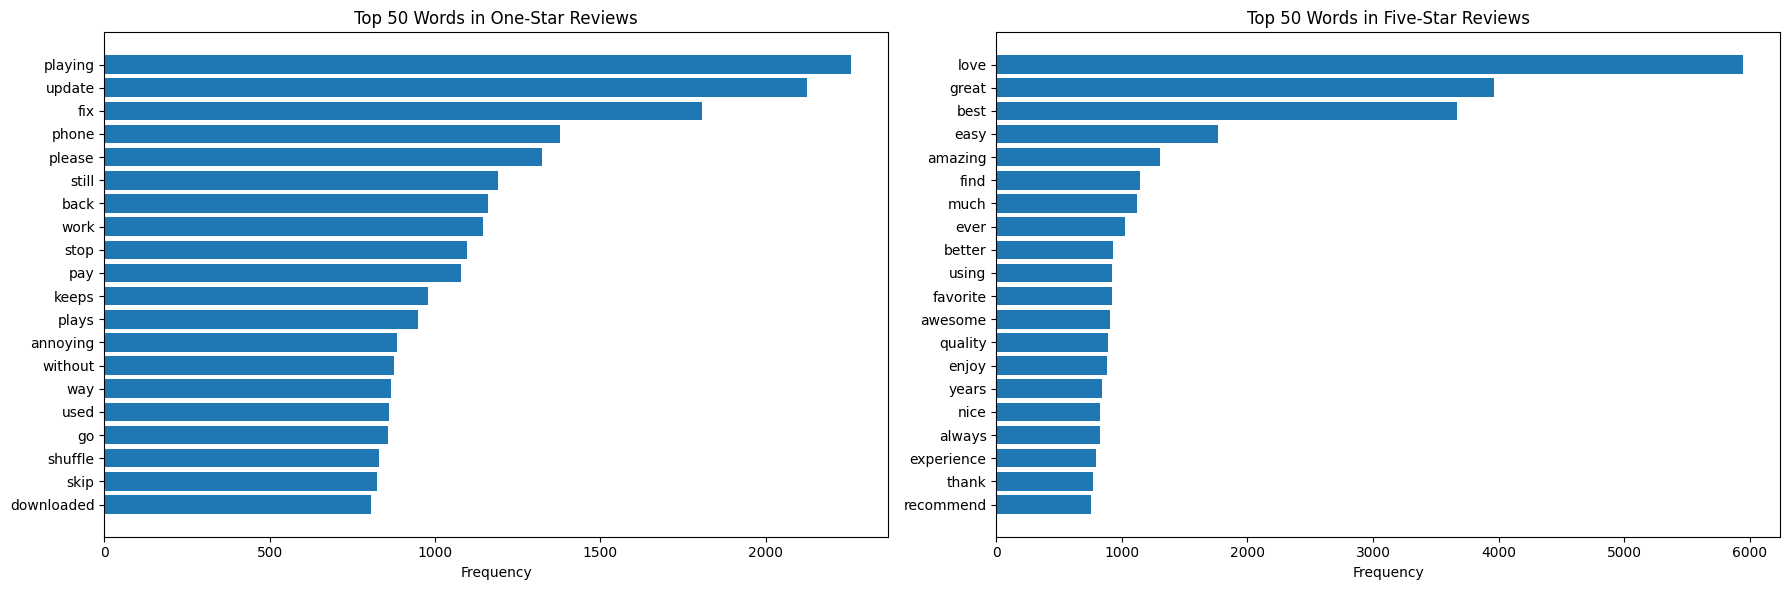

In [46]:
# plot top_50_one_star and top_50_five_star horizontally

# Extract words and frequencies for one-star reviews
one_star_words = list(top_50_one_star.keys())
one_star_freqs = list(top_50_one_star.values())

# Extract words and frequencies for five-star reviews
five_star_words = list(top_50_five_star.keys())
five_star_freqs = list(top_50_five_star.values())

plt.figure(figsize=(18, 6))  # Adjust figsize for one-star plot

plt.subplot(1, 2, 1)
plt.barh(one_star_words, one_star_freqs)
plt.xlabel("Frequency")
plt.title("Top 50 Words in One-Star Reviews")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(five_star_words, five_star_freqs)
plt.xlabel("Frequency")
plt.title("Top 50 Words in Five-Star Reviews")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Based from the charts above, we can guess how both lists differ from one another.

1. Five-star reviews:
- Easy use of the application
- Having good quality and good experience on using the app

2. One-star reviews:
- Some technical errors - not able to play the music
- asking the developer team to fix the app

Note that the one-star reviews might be similar to the deprecated outlier reviews (on March 8 and April 13-14, 2022, see the pre-processing chapter above) due to errors when playing the music, although the deprecated reviews might spread more widely that urgently needed a fix.